# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

# Project: Weather station

# Introduction et objectif

- Suppose there are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.
- The weather station in Paris breaks down
- Can we use the other stations to infer the weather in Paris?

<img alt="weather" src="images/map.png" width=400>

### Dataset

<img alt="weather" src="images/annual_temperature.png" width=400>

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

### First steps

- Look at the correlations between variables.
- What variable do I want to predict
- What time scale am interested in?
- Start with the easy predictions and move on to harder ones
- Are there events that are more predictable than others?

<Axes: xlabel='time'>

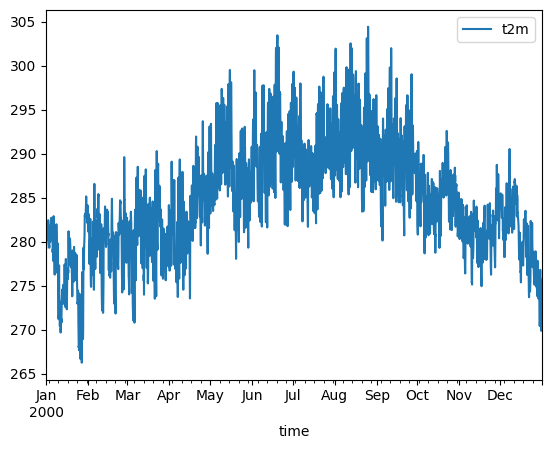

In [146]:
from pathlib import Path
import pandas as pd
import xarray as xr


import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

dir0 = Path('weather_data/paris/')
file_t2m = 't2m.nc'

ds = xr.open_dataset(Path(dir0, file_t2m))

# convert to pandas dataframe
df = ds.to_dataframe()

# remove latitude and longitude indices
df = df.droplevel([1,2])

df.loc['2000'].plot()

# Chargement et exploration du jeu de données

## Chargement des données

### Bibliothèques

In [147]:
# Librairies pour la manipulation des données (déjà partiellement importées)
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path

# Librairies pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# Pour la visualisation interactive (optionnel)
# import plotly.express as px 

# Librairies pour le Machine Learning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score


### Données

On charge les données et on les place dans un dataframe df_all

In [148]:
from pathlib import Path
import pandas as pd
import xarray as xr

base_dir = Path('weather_data') 
CITIES = ['paris', 'brest', 'london', 'marseille', 'berlin']
VARIABLES = ['t2m', 'skt', 'd2m', 'u10', 'v10', 'tcc', 'sp', 'tp', 'ssrd', 'blh'] 


def load_city_var(city: str, var: str = "t2m") -> pd.DataFrame:
    city_dir = base_dir / city
    file_path = city_dir / f"{var}.nc"
    
    ds = xr.open_dataset(file_path)
    
    # Conversion et nettoyage des indices (latitude, longitude)
    df = ds.to_dataframe()
    df = df.droplevel([1, 2])
    
    # Renommage de la colonne
    df = df[[var]].rename(columns={var: f"{var}_{city}"})
    
    return df

all_dfs = []
for city in CITIES:
    for var in VARIABLES:
            df_var = load_city_var(city, var)
            all_dfs.append(df_var)


df_all = pd.concat(all_dfs, axis=1)
print(f"Dimensions : {df_all.shape}")

Dimensions : (359431, 50)


On regarde les informations sur le jeu de données

In [149]:
print(df_all.head())
print(f"Taille initiale de df_all : {df_all.shape}")
df_all.dropna(inplace=True)
print(f"Taille finale de df_all après synchronisation : {df_all.shape}")

                      t2m_paris   skt_paris   d2m_paris  u10_paris  v10_paris  \
time                                                                            
1980-01-01 00:00:00  273.624573  271.886169  272.332703   1.821228   0.593918   
1980-01-01 01:00:00  273.590820  271.277069  272.302704   1.522354   0.792664   
1980-01-01 02:00:00  273.077484  271.015686  272.056641   1.478912   0.811569   
1980-01-01 03:00:00  272.647949  270.778687  271.807556   1.310043   0.710587   
1980-01-01 04:00:00  272.320129  269.853119  271.532471   1.426117   0.915924   

                     tcc_paris       sp_paris  tp_paris  ssrd_paris  \
time                                                                  
1980-01-01 00:00:00   1.000000  100071.015625       NaN         NaN   
1980-01-01 01:00:00   0.986572  100026.843750       NaN         NaN   
1980-01-01 02:00:00   1.000000   99995.453125       NaN         NaN   
1980-01-01 03:00:00   0.989990   99981.320312       NaN         NaN   
1980-0

On crée le dataframe contenant uniquement les températures a 2m t2m pour chaque ville

In [150]:
df_t2m = df_all.filter(regex='t2m_')
print(df_t2m.head())
print(f"Taille initiale de df_t2m : {df_t2m.shape}")
df_t2m.dropna(inplace=True)
print(f"Taille finale de df_t2m après synchronisation : {df_t2m.shape}")

                      t2m_paris   t2m_brest  t2m_london  t2m_marseille  \
time                                                                     
1980-01-01 07:00:00  272.039154  278.041107  270.650482     277.095795   
1980-01-01 08:00:00  272.022308  278.133636  270.973480     277.131683   
1980-01-01 09:00:00  271.751892  278.097595  271.242126     277.253845   
1980-01-01 10:00:00  274.506470  278.674438  272.447876     278.912720   
1980-01-01 11:00:00  275.079346  278.856689  272.575439     278.811768   

                     t2m_berlin  
time                             
1980-01-01 07:00:00  273.943451  
1980-01-01 08:00:00  273.512543  
1980-01-01 09:00:00  273.662048  
1980-01-01 10:00:00  274.168579  
1980-01-01 11:00:00  273.964111  
Taille initiale de df_t2m : (350633, 5)
Taille finale de df_t2m après synchronisation : (350633, 5)


C:\Users\nicol\AppData\Local\Temp\ipykernel_18924\3554003694.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Premières observations

### Statistiques générales

In [151]:
# Affichage de toutes les statistiques descriptives
df_all_description = df_all.describe().T

ordered_cols = []
for var in VARIABLES:
    for city in CITIES:
        ordered_cols.append(f'{var}_{city}')

df_description_ordered = df_all_description.loc[ordered_cols]
print(df_description_ordered)

                   count           mean            std           min  \
t2m_paris       350633.0     284.364105       7.123415    256.771332   
t2m_brest       350633.0     285.042236       4.206890    266.545654   
t2m_london      350633.0     283.669922       5.922341    257.483673   
t2m_marseille   350633.0     288.001648       6.454107    266.325012   
t2m_berlin      350633.0     282.741394       8.276489    251.373947   
skt_paris       350633.0     284.298798       7.725009    252.089996   
skt_brest       350633.0     285.286835       4.394971    268.572327   
skt_london      350633.0     283.487030       6.611135    253.604446   
skt_marseille   350633.0     288.421844       6.689270    269.696289   
skt_berlin      350633.0     282.763336       8.779633    248.752258   
d2m_paris       350633.0     280.450897       5.701001    254.678604   
d2m_brest       350633.0     281.943237       4.549535    256.819458   
d2m_london      350633.0     280.181183       5.071845    256.20

D'après le tableau ci-dessus, on peut faire quelques observations pour chaque variable :

- $\texttt{t2m}$ (Température à 2 mètres, K)
    - Moyenne : Varie de $\texttt{t2m\_berlin}$ ($282.74$ K) à $\texttt{t2m\_marseille}$ ($288.00$ K). Marseille est la ville la plus chaude en moyenne.
    - Variabilité ($\sigma$) : $\texttt{t2m\_berlin}$ ($8.28$ K) et $\texttt{t2m\_paris}$ ($7.12$ K) montrent le plus grand écart-type. $\texttt{t2m\_brest}$ ($4.21$ K) est la plus stable (climat océanique?)

- $\texttt{skt}$ (Température de la peau, K)
    - Les statistiques sont très proches de $\texttt{t2m}$ pour toutes les villes

- $\texttt{d2m}$ (Point de rosée à 2m, K)
    - Toujours inférieur à $\texttt{t2m}$

- $\texttt{u10}$ et $\texttt{v10}$ (Composantes du vent (vertical et horizontal) à 10m, $m/s$)
    - Moyenne : Proche de zéro pour toutes les villes (pas de direction dominante).
    - Variabilité ($\sigma$) : Les vents sont les plus variables à $\texttt{u10\_brest}$ ($\approx 4.2$ $m/s$) et $\texttt{u10\_marseille}$ ($\approx 4.0$ $m/s$),

- $\texttt{tcc}$ (Couverture nuageuse totale, compris dans $0-1$)
    - Moyenne : $\texttt{tcc\_marseille}$ est la plus faible ($\approx 0.43$). Les autres villes sont majoritairement couvertes (moyennes $\approx 0.66$ à $0.69$).

- $\texttt{sp}$ (Pression de surface, Pa)
    - Moyenne : Toutes les villes sont proches de $100 000$ Pa.
    - Variabilité ($\sigma$) : L'écart-type est très faible ($\approx 1000$ Pa), une grande stabilité de la pression

- $\texttt{tp}$ (Précipitations totales, m)
    - Moyenne : Très faible ($\approx 10^{-4}$ $m/h$). $\texttt{tp\_brest}$ est la plus élevée.

- $\texttt{ssrd}$ (Rayonnement solaire, $J/m^2$)
    - Moyenne : $\texttt{ssrd\_marseille}$ reçoit le plus de rayonnement solaire ($676622$ $J/m^2$).

- $\texttt{blh}$ (Hauteur de la couche limite, m)
    - Moyenne : Varie de $505$ m (Marseille) à $668$ m (Brest).
    - Variabilité : $\texttt{blh\_berlin}$ ($491.53$ m) et $\texttt{blh\_paris}$ ($470.67$ m) ont la plus grande variabilité.

### Corrélations

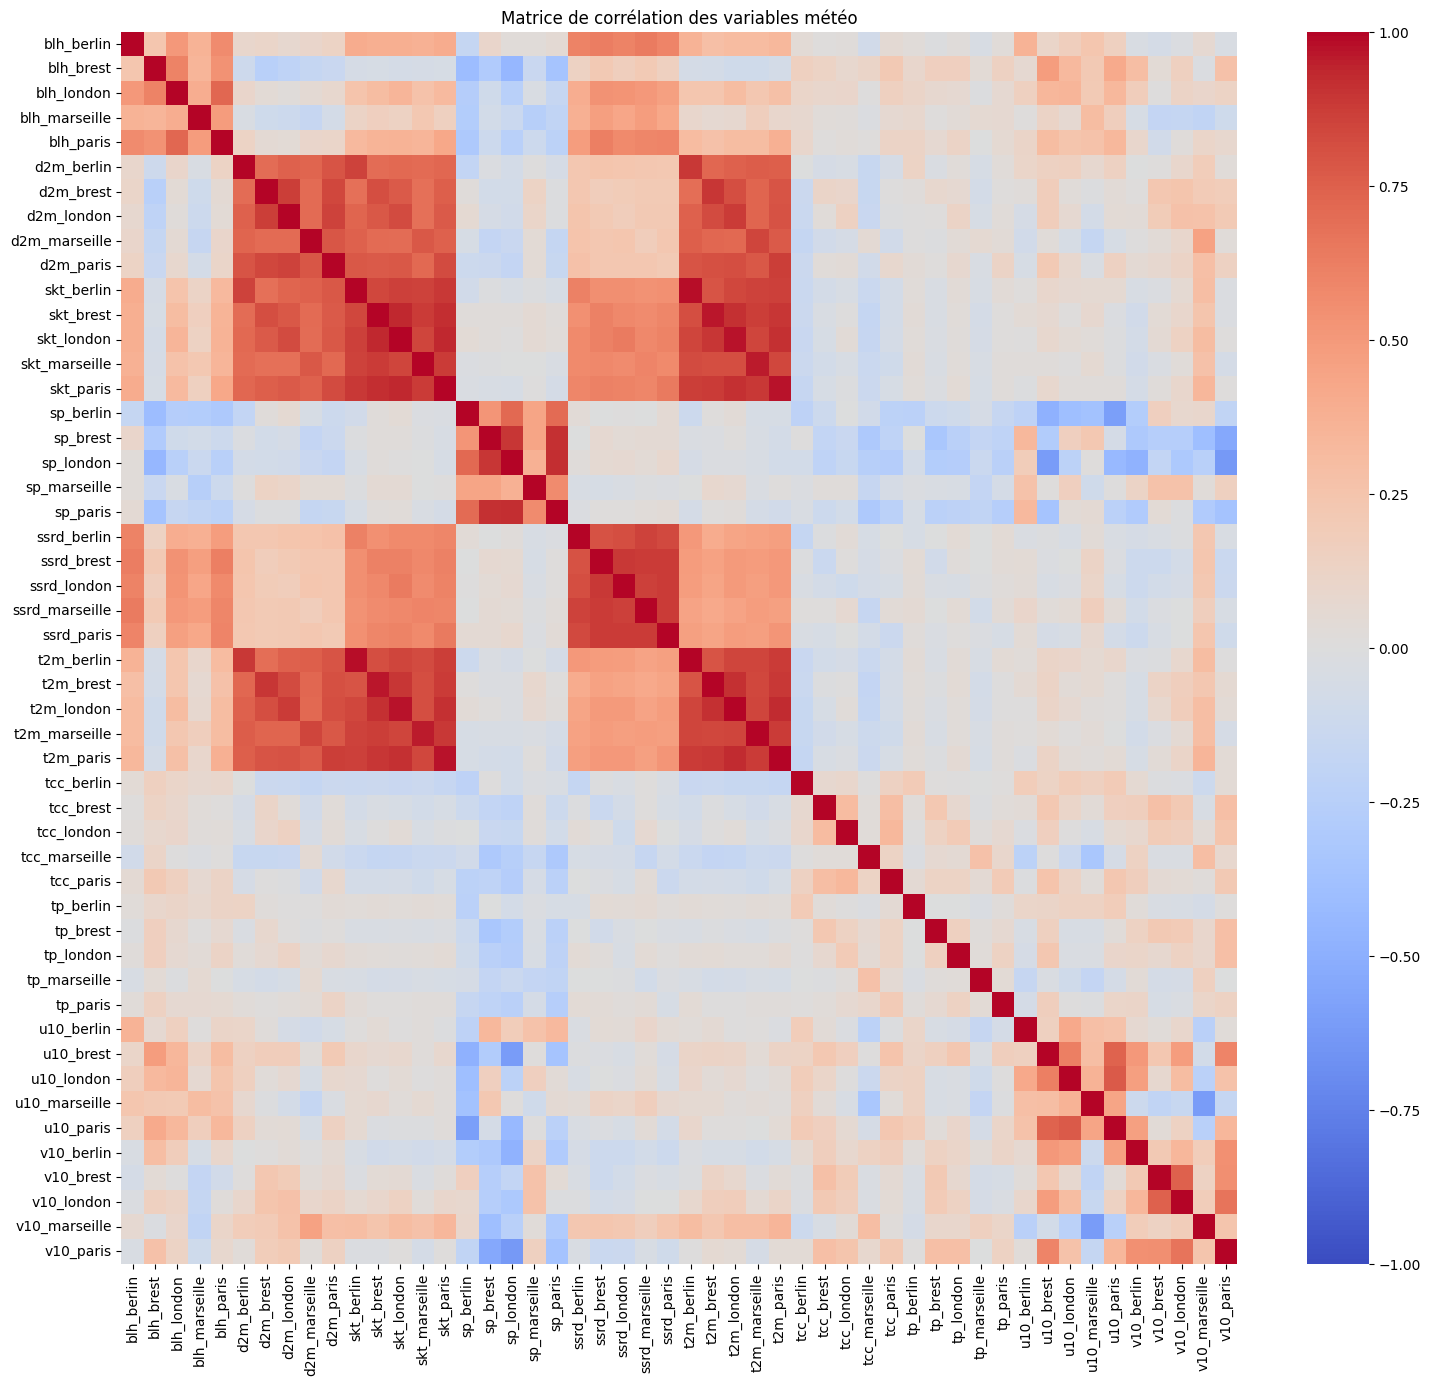

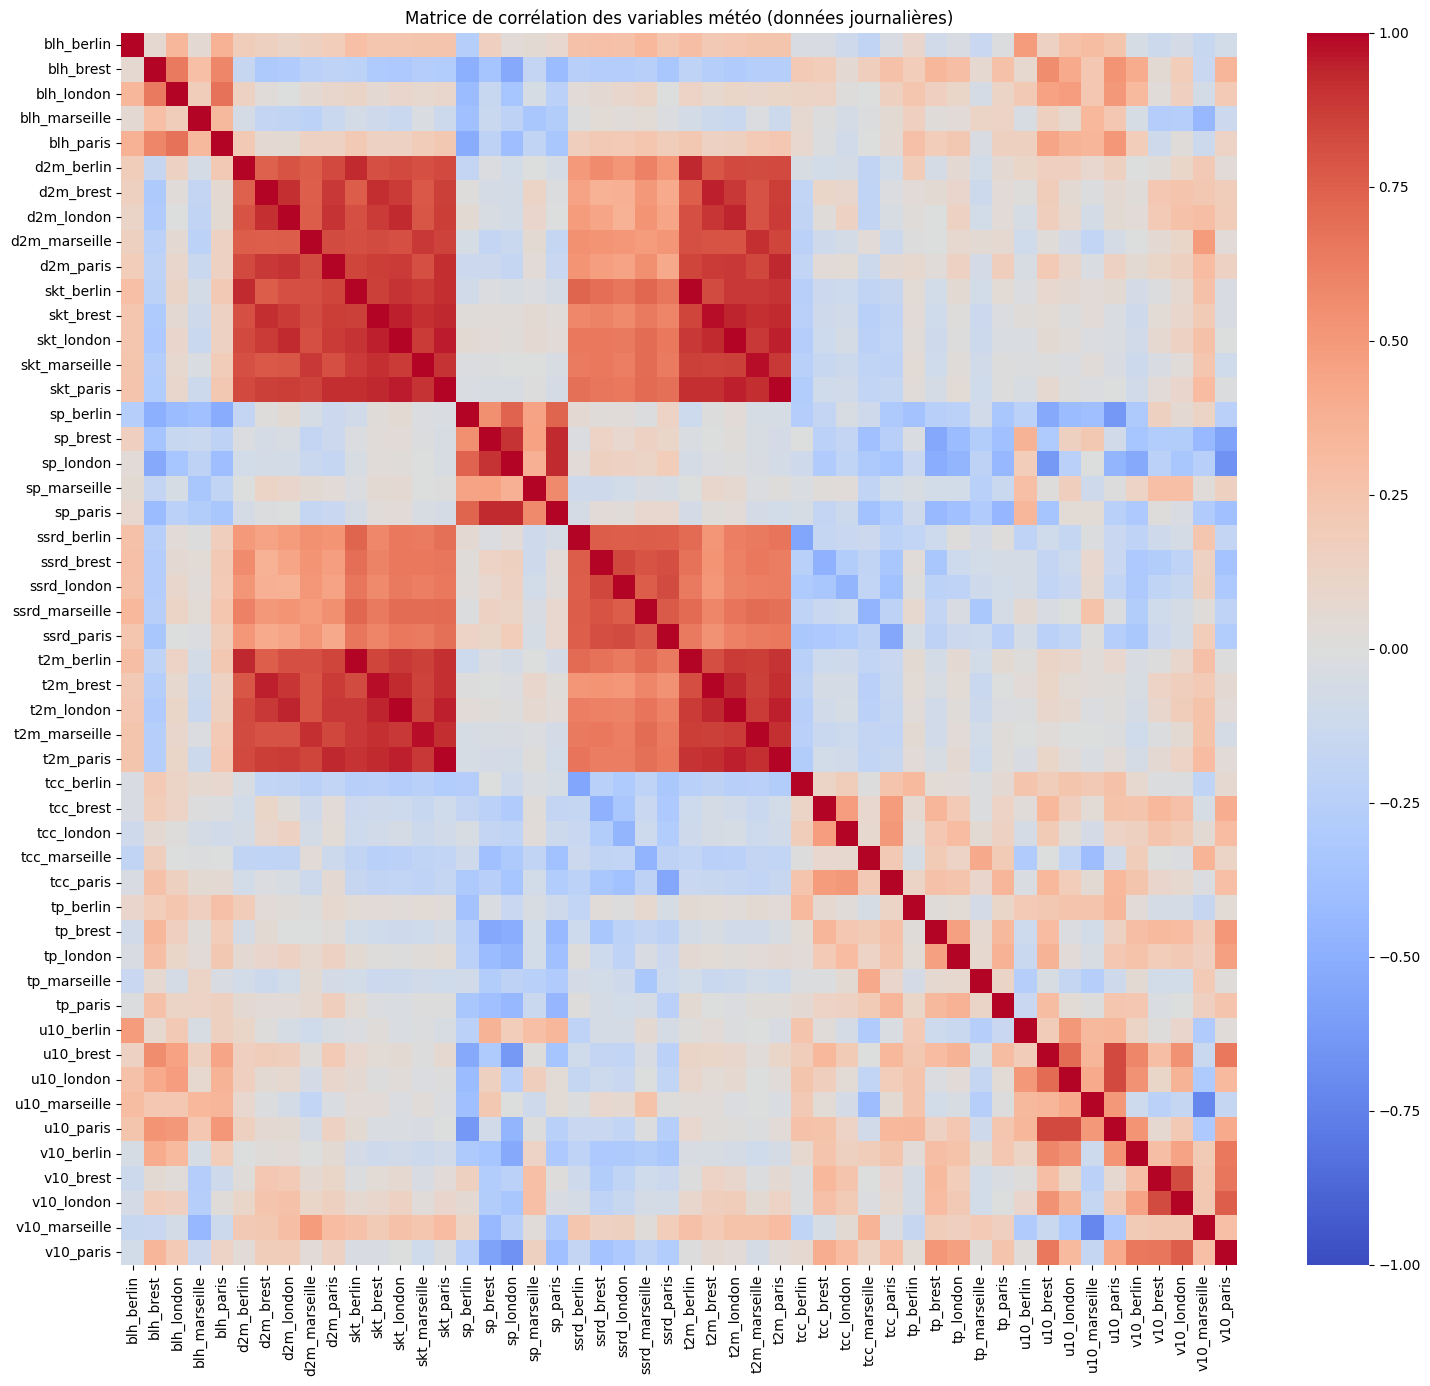

In [152]:
corr_matrix = df_all.corr()
sorted_cols = sorted(df_all.columns)
plt.figure(figsize=(18,16))
sns.heatmap(corr_matrix.loc[sorted_cols, sorted_cols], cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice de corrélation des variables météo")
plt.show()

#On trace également les correlations pour les variables rééchantillonées en données journalières
df_all_daily = df_all.resample('D').mean()
corr_matrix_daily = df_all_daily.corr()
plt.figure(figsize=(18,16))
sns.heatmap(corr_matrix_daily.loc[sorted_cols, sorted_cols], cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice de corrélation des variables météo (données journalières)")
plt.show()

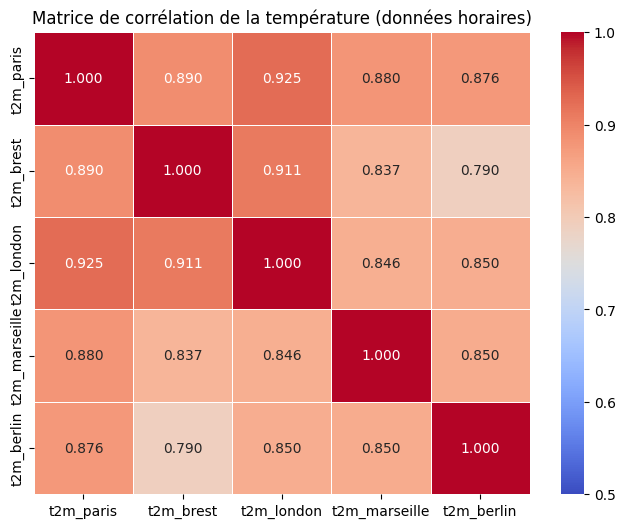

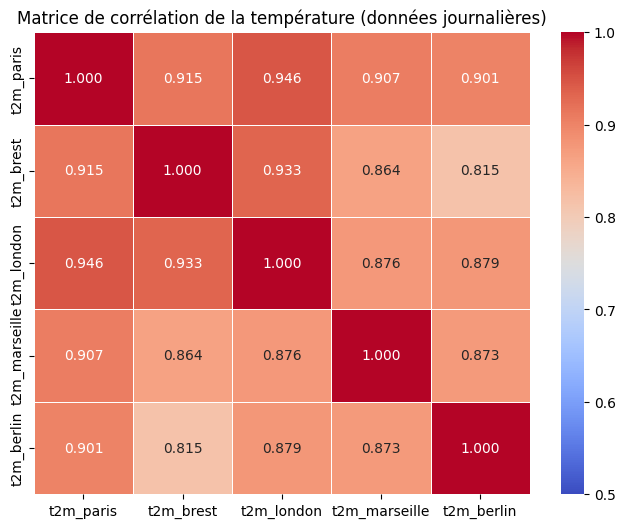

In [153]:
# rééchantillonage de la matrice df_t2m en données journalières
df_t2m_daily = df_t2m.resample('D').mean()

#On va tracer les correlations entre les différentes villes pour la variable t2m uniquement, avec les données rééchantillonnées en données horaires et les données brutes
corr_matrix_t2m = df_t2m.corr()
corr_matrix_t2m_daily = df_t2m_daily.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_t2m, annot=True, cmap='coolwarm', fmt=".3f",vmin=0.5, vmax=1,linewidths=.5)
plt.title("Matrice de corrélation de la température (données horaires)")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_t2m_daily, annot=True, cmap='coolwarm', fmt=".3f",vmin=0.5, vmax=1,linewidths=.5)
plt.title("Matrice de corrélation de la température (données journalières)")
plt.show()


Le rééchantillonage en données journalières a pour effet d'augmenter les correlations fortes. Les corrélations déja fortes deviennent encore plus fortes.

La température à Paris est fortement corrélée à celle des autres villes (Londres en particulier), on devrait pouvoir la reconstruire à partir de ces données. On trace les températures de plusieurs villes sur une année, pour observer.

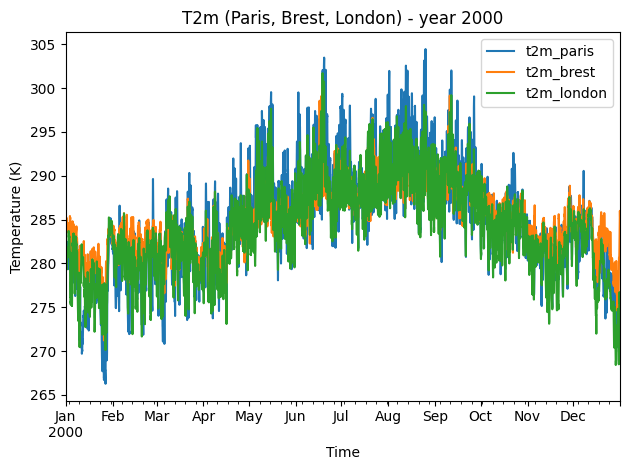

In [154]:
# On prend par exemple l'année 2000 pour ne pas avoir un plot énorme
df_2000 = df_t2m["2000-01-01":"2000-12-31"]

ax = df_2000[["t2m_paris", "t2m_brest", "t2m_london"]].plot()
ax.set_title("T2m (Paris, Brest, London) - year 2000")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature (K)")
plt.tight_layout()
plt.show()


Sur l'année 2000, on observe bien que les températures dans les trois villes ont des tendances similaires

# Premier modèle simple : régression linéaire

On choisit "t2m_paris" comme variable à prédire et on travaille sur des données horaires puis sur les moyennes journalières. On commence simplement par prendre des données de train avant 2010 et de test après 2010

RMSE sur l'ensemble du test (après 2010-01-01): 2.287 K / °C
R² sur l'ensemble du test (après 2010-01-01): 0.8992
        Variable     Coeff
0      t2m_brest  0.310591
1     t2m_london  0.491277
2  t2m_marseille  0.219218
3     t2m_berlin  0.187665


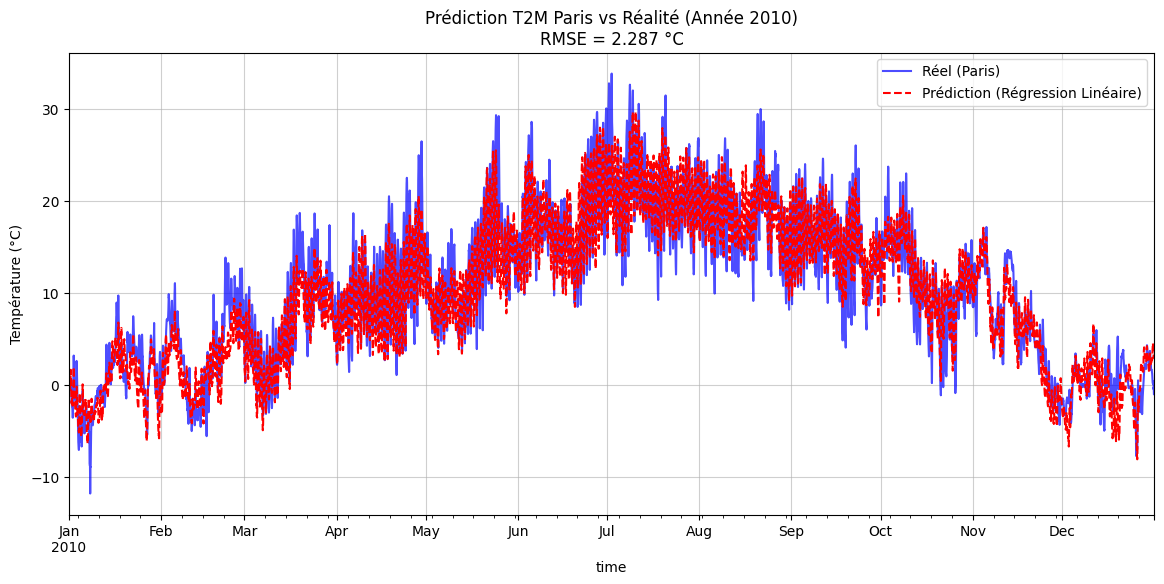

In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

target_col = "t2m_paris"
feature_cols = [c for c in df_t2m.columns if c != target_col] 

X = df_t2m[feature_cols]
y = df_t2m[target_col]

split_date = "2010-01-01"

# Entraînement avant 2010
X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]

# Test à partir de 2010
X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]


model = LinearRegression()
model.fit(X_train, y_train)
y_pred_series = pd.Series(model.predict(X_test), index=y_test.index)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_series))
print(f"RMSE sur l'ensemble du test (après {split_date}): {rmse_test:.3f} K / °C")

r2_test = r2_score(y_test, y_pred_series)
print(f"R² sur l'ensemble du test (après {split_date}): {r2_test:.4f}")

df_coef = pd.DataFrame({'Variable': X.columns, 'Coeff': model.coef_})
print(df_coef)

y_test_2010 = y_test.loc['2010']
y_pred_2010 = y_pred_series.loc['2010']


y_test_2010_C = y_test_2010 - 273.15
y_pred_2010_C = y_pred_2010 - 273.15

plt.figure(figsize=(14, 6))
y_test_2010_C.plot(label='Réel (Paris)', color='blue', alpha=0.7)
y_pred_2010_C.plot(label='Prédiction (Régression Linéaire)', color='red', linestyle='--')
plt.title(f"Prédiction T2M Paris vs Réalité (Année 2010)\nRMSE = {rmse_test:.3f} °C")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()


RMSE sur l'ensemble du test (après 2010-01-01): 1.746 K / °C
R² sur l'ensemble du test (après 2010-01-01): 0.9280
        Variable     Coeff
0      t2m_brest  0.314446
1     t2m_london  0.487472
2  t2m_marseille  0.211600
3     t2m_berlin  0.184211


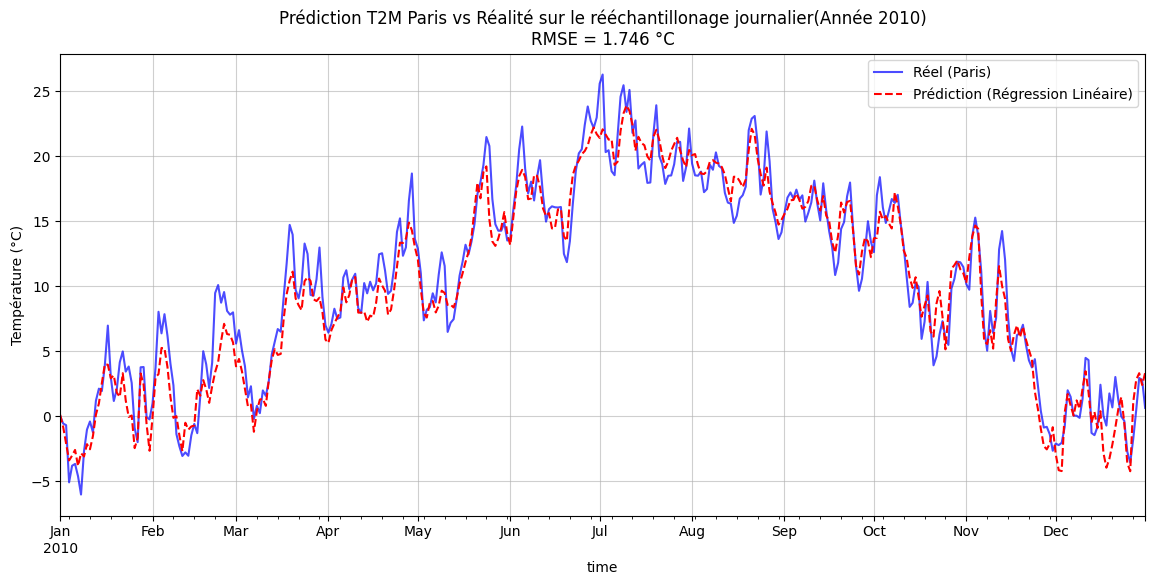

In [171]:
target_col = "t2m_paris"
feature_cols = [c for c in df_t2m_daily.columns if c != target_col] 

X = df_t2m_daily[feature_cols]
y = df_t2m_daily[target_col]

split_date = "2010-01-01"

# Entraînement avant 2010
X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]

# Test à partir de 2010
X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]


model = LinearRegression()
model.fit(X_train, y_train)
y_pred_series = pd.Series(model.predict(X_test), index=y_test.index)


rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_series))
print(f"RMSE sur l'ensemble du test (après {split_date}): {rmse_test:.3f} K / °C")

r2_test = r2_score(y_test, y_pred_series)
print(f"R² sur l'ensemble du test (après {split_date}): {r2_test:.4f}")

df_coef = pd.DataFrame({'Variable': X.columns, 'Coeff': model.coef_})
print(df_coef)

y_test_2010 = y_test.loc['2010']
y_pred_2010 = y_pred_series.loc['2010']


y_test_2010_C = y_test_2010 - 273.15
y_pred_2010_C = y_pred_2010 - 273.15

plt.figure(figsize=(14, 6))
y_test_2010_C.plot(label='Réel (Paris)', color='blue', alpha=0.7)
y_pred_2010_C.plot(label='Prédiction (Régression Linéaire)', color='red', linestyle='--')
plt.title(f"Prédiction T2M Paris vs Réalité sur le rééchantillonage journalier(Année 2010)\nRMSE = {rmse_test:.3f} °C")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()


Le modèle reproduit bien les tendances avec un R² proche de 1. On est plus précis sur les données rééchantillonnées.

## Ajout de davantage de features

On essaye de prédire t2m en fonction de toutes les autres features cette fois ci. On rescale les données pour pouvoir avoir des conclusions sur les coefficients et l'importance des features.

RMSE sur l'ensemble du test (après 2010-01-01): 2.116 K / °C
R² sur l'ensemble du test (après 2010-01-01): 0.9137
          Variable     Coeff
10      t2m_london  3.039351
0        t2m_brest  2.337472
20   t2m_marseille  2.312402
30      t2m_berlin  1.911922
1        skt_brest -1.115848
21   skt_marseille -1.029282
32      d2m_berlin -0.669323
28  ssrd_marseille  0.643684
12      d2m_london -0.521872
3        u10_brest  0.412709
14      v10_london -0.372872
36       sp_berlin -0.332052
24   v10_marseille  0.315165
11      skt_london  0.302761
34      v10_berlin -0.282631
29   blh_marseille -0.253927
19      blh_london -0.217761
33      u10_berlin -0.203706
8       ssrd_brest  0.187753
26    sp_marseille  0.176392
23   u10_marseille -0.167108
2        d2m_brest  0.166311
15      tcc_london -0.161004
38     ssrd_berlin -0.149672
6         sp_brest -0.149469
18     ssrd_london -0.112920
5        tcc_brest  0.109284
35      tcc_berlin -0.106474
16       sp_london -0.101659
9        blh_bre

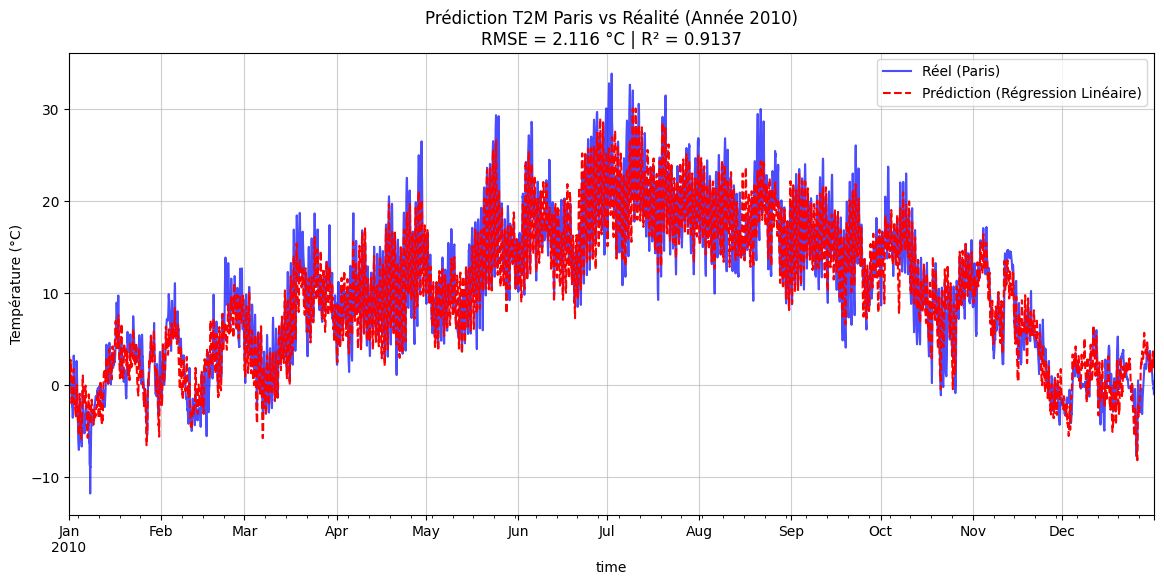

In [177]:
target_col = "t2m_paris"
feature_cols = [c for c in df_all.columns if c != target_col and not c.endswith('paris')]

X = df_all[feature_cols]
y = df_all[target_col]

split_date = "2010-01-01"

X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]

X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred_series = pd.Series(model.predict(X_test_scaled), index=y_test.index)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_series))
print(f"RMSE sur l'ensemble du test (après {split_date}): {rmse_test:.3f} K / °C")

r2_test = r2_score(y_test, y_pred_series)
print(f"R² sur l'ensemble du test (après {split_date}): {r2_test:.4f}")

df_coef = pd.DataFrame({'Variable': X.columns, 'Coeff': model.coef_})
df_coef['Abs_Coeff'] = df_coef['Coeff'].abs()
df_coef = df_coef.sort_values(by='Abs_Coeff', ascending=False)
print(df_coef.drop(columns=['Abs_Coeff']))

y_test_2010 = y_test.loc['2010']
y_pred_2010 = y_pred_series.loc['2010']

y_test_2010_C = y_test_2010 - 273.15
y_pred_2010_C = y_pred_2010 - 273.15

plt.figure(figsize=(14, 6))
y_test_2010_C.plot(label='Réel (Paris)', color='blue', alpha=0.7)
y_pred_2010_C.plot(label='Prédiction (Régression Linéaire)', color='red', linestyle='--')
plt.title(f"Prédiction T2M Paris vs Réalité (Année 2010)\nRMSE = {rmse_test:.3f} °C | R² = {r2_test:.4f}")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

RMSE sur l'ensemble du test (après 2010-01-01): 1.560 K / °C
R² sur l'ensemble du test (après 2010-01-01): 0.9426
          Variable     Coeff
10      t2m_london  3.402906
30      t2m_berlin  2.740114
20   t2m_marseille  1.842374
0        t2m_brest  1.545558
31      skt_berlin -1.542935
21   skt_marseille -1.064772
6         sp_brest -0.855172
16       sp_london  0.805418
3        u10_brest  0.652963
28  ssrd_marseille  0.639094
11      skt_london -0.567065
14      v10_london -0.523628
32      d2m_berlin -0.447830
36       sp_berlin -0.368058
22   d2m_marseille  0.353298
23   u10_marseille -0.332301
1        skt_brest -0.312824
34      v10_berlin -0.305512
2        d2m_brest  0.303212
12      d2m_london -0.296081
13      u10_london  0.293302
8       ssrd_brest -0.222285
33      u10_berlin -0.211509
29   blh_marseille -0.183240
19      blh_london -0.174357
15      tcc_london -0.172822
26    sp_marseille  0.152442
24   v10_marseille  0.131490
18     ssrd_london  0.130769
38     ssrd_berl

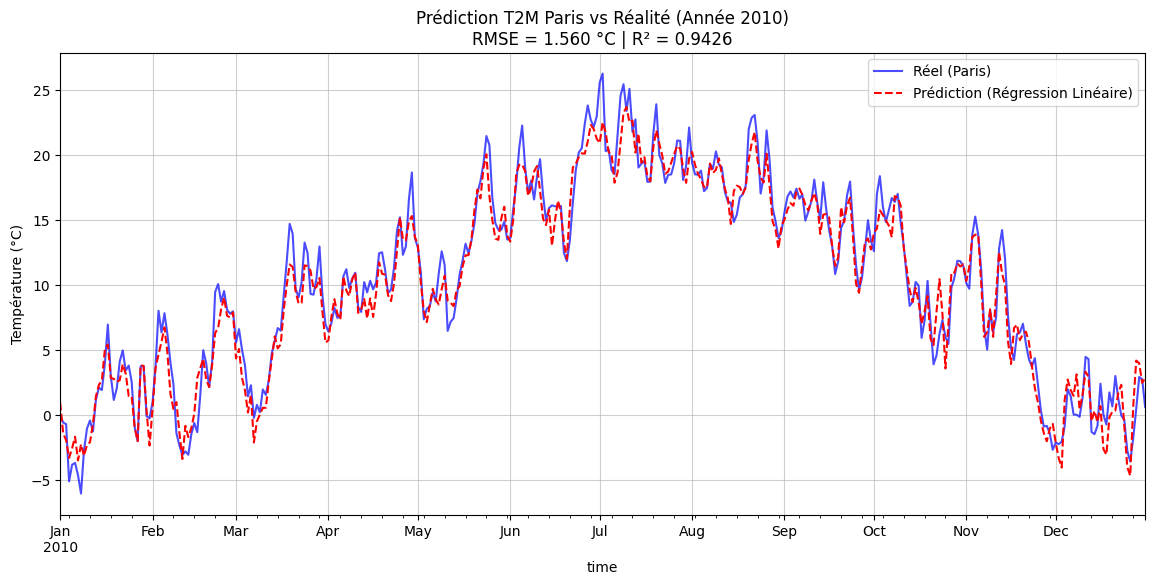

In [178]:
target_col = "t2m_paris"
feature_cols = [c for c in df_all.columns if c != target_col and not c.endswith('paris')]

X = df_all_daily[feature_cols]
y = df_all_daily[target_col]

split_date = "2010-01-01"

X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]

X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred_series = pd.Series(model.predict(X_test_scaled), index=y_test.index)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_series))
print(f"RMSE sur l'ensemble du test (après {split_date}): {rmse_test:.3f} K / °C")

r2_test = r2_score(y_test, y_pred_series)
print(f"R² sur l'ensemble du test (après {split_date}): {r2_test:.4f}")

df_coef = pd.DataFrame({'Variable': X.columns, 'Coeff': model.coef_})
df_coef['Abs_Coeff'] = df_coef['Coeff'].abs()
df_coef = df_coef.sort_values(by='Abs_Coeff', ascending=False)
print(df_coef.drop(columns=['Abs_Coeff']))

y_test_2010 = y_test.loc['2010']
y_pred_2010 = y_pred_series.loc['2010']

y_test_2010_C = y_test_2010 - 273.15
y_pred_2010_C = y_pred_2010 - 273.15

plt.figure(figsize=(14, 6))
y_test_2010_C.plot(label='Réel (Paris)', color='blue', alpha=0.7)
y_pred_2010_C.plot(label='Prédiction (Régression Linéaire)', color='red', linestyle='--')
plt.title(f"Prédiction T2M Paris vs Réalité (Année 2010)\nRMSE = {rmse_test:.3f} °C | R² = {r2_test:.4f}")
plt.ylabel("Température (°C)")
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

On voit que la température à Paris peut être prédite avec une très bonne précision à partir des autres villes (R²=0.92 sur les données horaires)
L’ajout d’autres variables météo améliore l’erreur absolue, ces paramètres apportent une information complémentaire, mais leurs coefficients sont significativement plus faibles.

In [179]:
import plotly.graph_objects as go
import pandas as pd

df = df_all_daily.copy()
df["dayofyear"] = df.index.dayofyear

cities = ["brest", "marseille", "london", "berlin"]
variables = ["t2m", "ssrd", "u10", "v10", "tcc", "sp", "blh"]

corrs = []
for day in range(1, 367):
    subset = df[df["dayofyear"] == day]
    if len(subset) > 10:
        corr = subset.corrwith(subset["t2m_paris"])
        corrs.append(corr)

corr_df = pd.DataFrame(corrs, index=range(1, len(corrs)+1))
corr_df.index.name = "dayofyear"

# Créer une trace par variable et par ville
fig = go.Figure()

for city in cities:
    for var in variables:
        col = f"{var}_{city}"
        if col in corr_df.columns:
            fig.add_trace(go.Scatter(
                x=corr_df.index,
                y=corr_df[col],
                mode='lines',
                name=f"{var} ({city})",
                visible=(city == "paris")  # seule Paris visible par défaut
            ))

# Menu déroulant
buttons = []
for i, city in enumerate(cities):
    visible = [False] * len(fig.data)
    for j, var in enumerate(variables):
        idx = i * len(variables) + j
        visible[idx] = True
    buttons.append(dict(
        label=city.capitalize(),
        method="update",
        args=[{"visible": visible},
              {"title": f"Corrélation moyenne avec t2m_paris – {city.capitalize()}"}]
    ))

fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        x=0.1, y=1.15
    )],
    title="Corrélation moyenne avec t2m_paris – sélection de la ville",
    xaxis_title="Jour de l'année",
    yaxis_title="Corrélation",
    hovermode="x unified"
)

fig.show()


c:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning:

invalid value encountered in divide

c:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning:

invalid value encountered in divide



# PCA

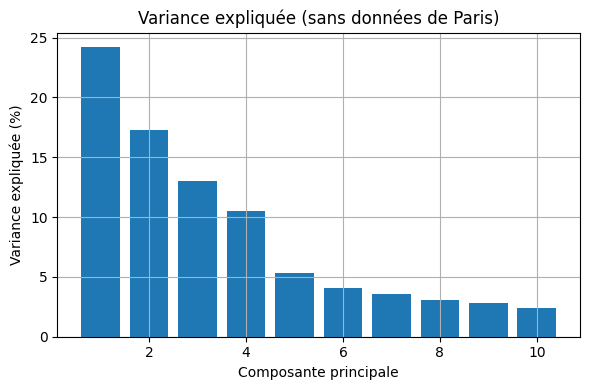

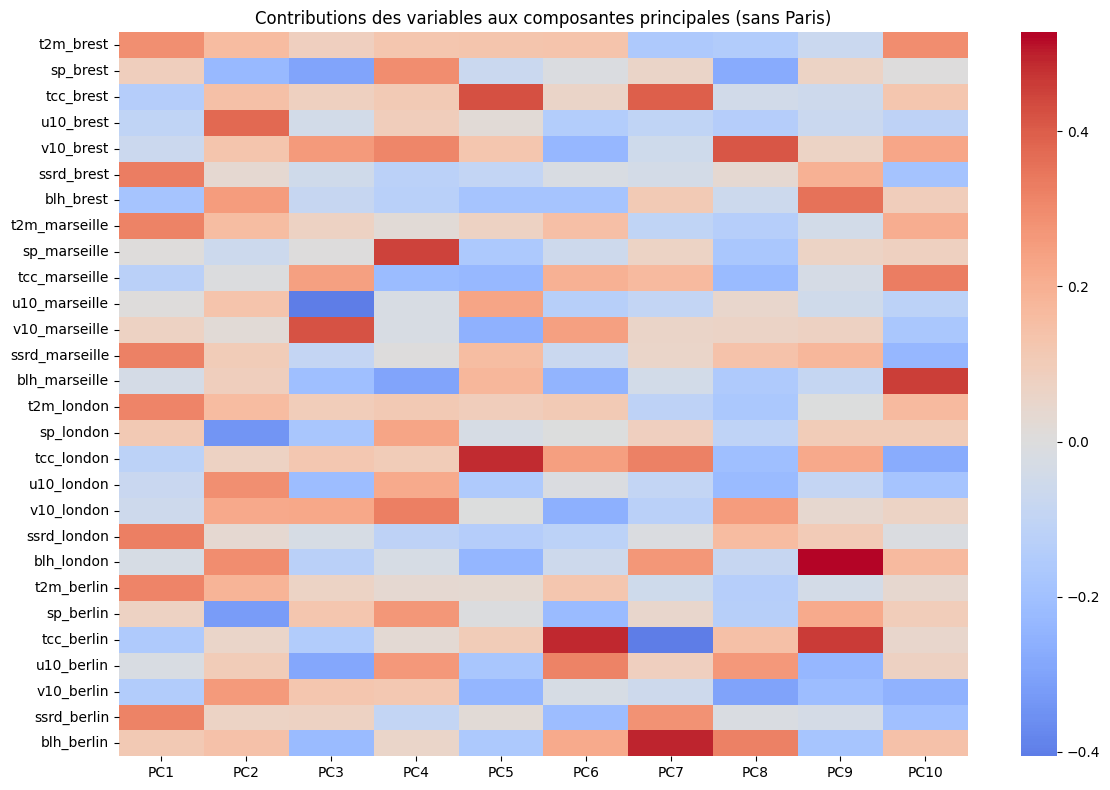

In [92]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X = df_all.loc[:, ~df_all.columns.str.endswith("_paris")].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


n_components = 10
pca = PCA(n_components)
Z = pca.fit_transform(X_scaled)


df_pca = pd.DataFrame(Z, index=X.index, columns=[f"PC{i+1}" for i in range(pca.n_components_)])


plt.figure(figsize=(6,4))
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_ * 100)
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée (%)")
plt.title("Variance expliquée (sans données de Paris)")
plt.grid(True)
plt.tight_layout()
plt.show()


loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i+1}" for i in range(n_components)]
)

plt.figure(figsize=(12,8))
sns.heatmap(loadings, cmap="coolwarm", center=0)
plt.title("Contributions des variables aux composantes principales (sans Paris)")
plt.tight_layout()
plt.show()


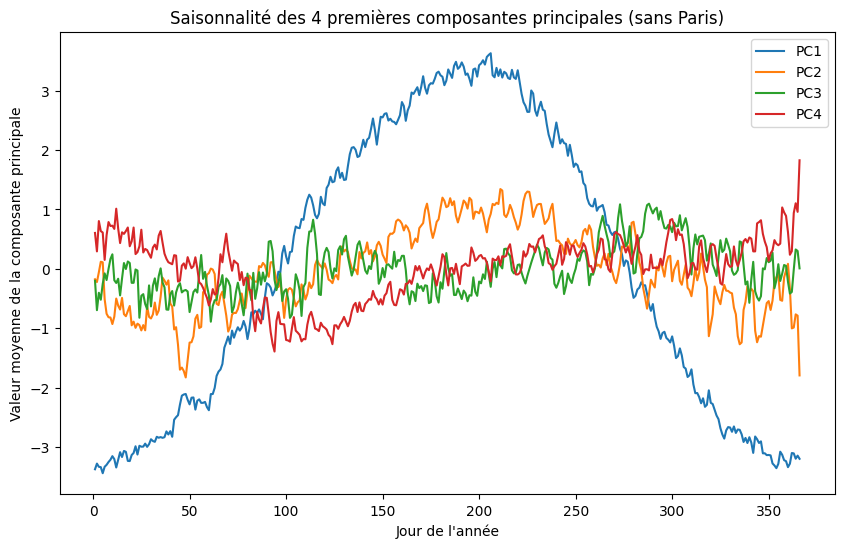

In [181]:
plt.figure(figsize=(10,6))
df_pca["dayofyear"] = df_pca.index.dayofyear
df_pca.groupby("dayofyear")["PC1"].mean().plot()
df_pca.groupby("dayofyear")["PC2"].mean().plot()
df_pca.groupby("dayofyear")["PC3"].mean().plot()
df_pca.groupby("dayofyear")["PC4"].mean().plot()
plt.xlabel("Jour de l'année")
plt.ylabel("Valeur moyenne de la composante principale")
plt.title("Saisonnalité des 4 premières composantes principales (sans Paris)")
plt.legend(["PC1", "PC2", "PC3", "PC4"])
plt.show()



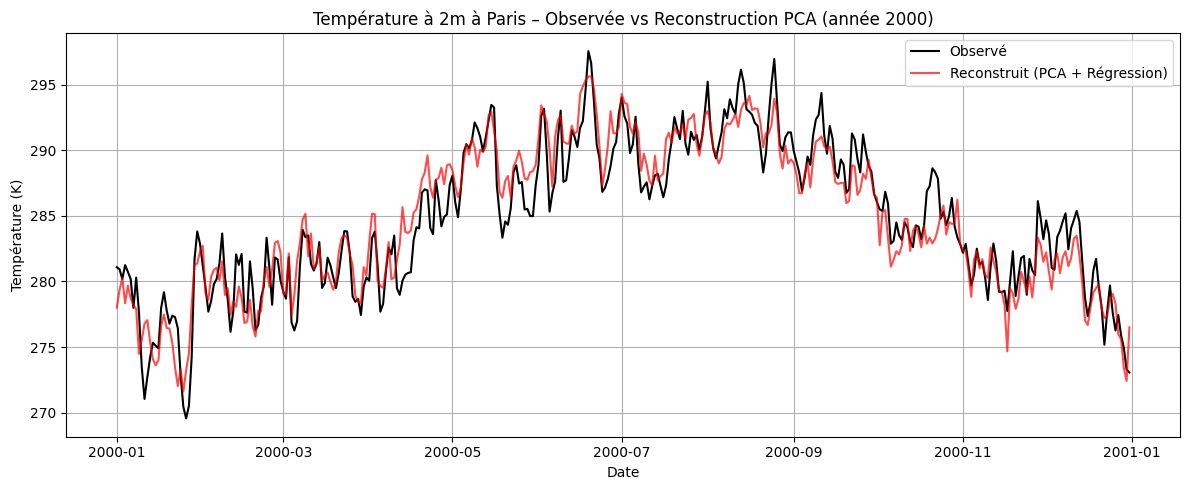

R² global : 0.896
RMSE global : 2.096 K


In [94]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Données d'entrée : on prend quelques composantes principales
X_pca = df_pca[["PC1", "PC2", "PC3", "PC4","PC5","PC6"]]
y = df_all["t2m_paris"].loc[X_pca.index]  # s'assure que les index correspondent

# Entraînement du modèle linéaire
model = LinearRegression()
model.fit(X_pca, y)
y_pred = model.predict(X_pca)

# On met les prédictions dans un Df
df_pred = pd.DataFrame({
    "t2m_paris_real": y,
    "t2m_paris_pred": y_pred
}, index=X_pca.index)

df_2000 = df_pred["2000-01-01":"2000-12-31"]

plt.figure(figsize=(12,5))
plt.plot(df_2000.index, df_2000["t2m_paris_real"], label="Observé", color="black", linewidth=1.5)
plt.plot(df_2000.index, df_2000["t2m_paris_pred"], label="Reconstruit (PCA + Régression)", color="red", alpha=0.7)
plt.title("Température à 2m à Paris – Observée vs Reconstruction PCA (année 2000)")
plt.xlabel("Date")
plt.ylabel("Température (K)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

r2 = r2_score(y, y_pred)
print(f"R² global : {r2:.3f}")
rmse = mean_squared_error(y, y_pred) ** 0.5  # √MSE
print(f"RMSE global : {rmse:.3f} K")



# Ridge

Meilleur Alpha trouvé : 206.9138


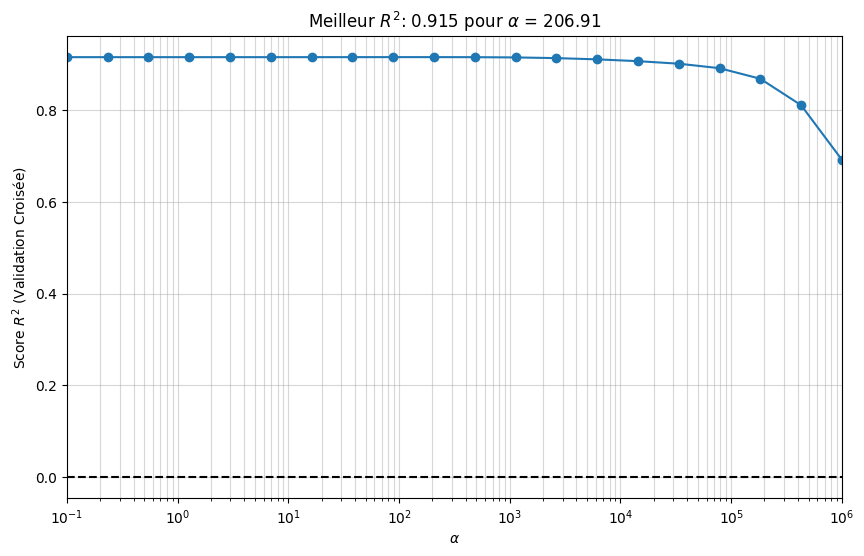

Test sur les données de 2010 et après
Score R² réel sur le jeu de Test (2010+) : 0.9142


In [185]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

target_col = "t2m_paris"
feature_cols = [c for c in df_all.columns if c != target_col and not c.endswith('paris')]

X = df_all[feature_cols]
y = df_all[target_col]

split_date = "2010-01-01"

X_cv = X.loc[X.index < split_date]
y_cv = y.loc[y.index < split_date]

X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]

#Scaling
scaler = StandardScaler()
X_cv_scaled = scaler.fit_transform(X_cv)
X_test_scaled = scaler.transform(X_test)

ALPHA_RNG_RIDGE = np.logspace(-1, 6, 20)
complexity_rng = ALPHA_RNG_RIDGE

# TSS pour respecter le mélange
cv_split = TimeSeriesSplit(n_splits=5)

r2_validation = np.empty(complexity_rng.shape)
coefs = np.empty((len(complexity_rng), X.shape[1]))


# Loop over regularization-parameter values
for k, complexity in enumerate(complexity_rng):
    reg = Ridge(alpha=complexity)

    r2_validation_arr = cross_val_score(reg, X_cv_scaled, y_cv, cv=cv_split, scoring='r2')
    
    r2_validation[k] = r2_validation_arr.mean()
    
    reg.fit(X_cv_scaled, y_cv)
    coefs[k] = reg.coef_


i_best = np.argmax(r2_validation)
complexity_best = complexity_rng[i_best]
r2_best = r2_validation[i_best]
coefs_best = coefs[i_best]

print(f"Meilleur Alpha trouvé : {complexity_best:.4f}")


complexity_label = r'$\alpha$'
plt.figure(figsize=(10, 6))
plt.plot(complexity_rng, r2_validation, marker='o')
plt.hlines(0., *complexity_rng[[0, -1]], colors='k', linestyles='--')
plt.xscale('log')
plt.xlabel(complexity_label)
plt.ylabel(r'Score $R^2$ (Validation Croisée)')
plt.title(r'Meilleur $R^2$: {:.3f} pour $\alpha$ = {:.2f}'.format(
    r2_best, complexity_best))
plt.xlim(complexity_rng[[0, -1]])
plt.grid(True, which="both", alpha=0.5)
plt.show()



Résultats Finaux (Alpha = 206.91)
RMSE sur le Test (2010+) : 2.110 °C


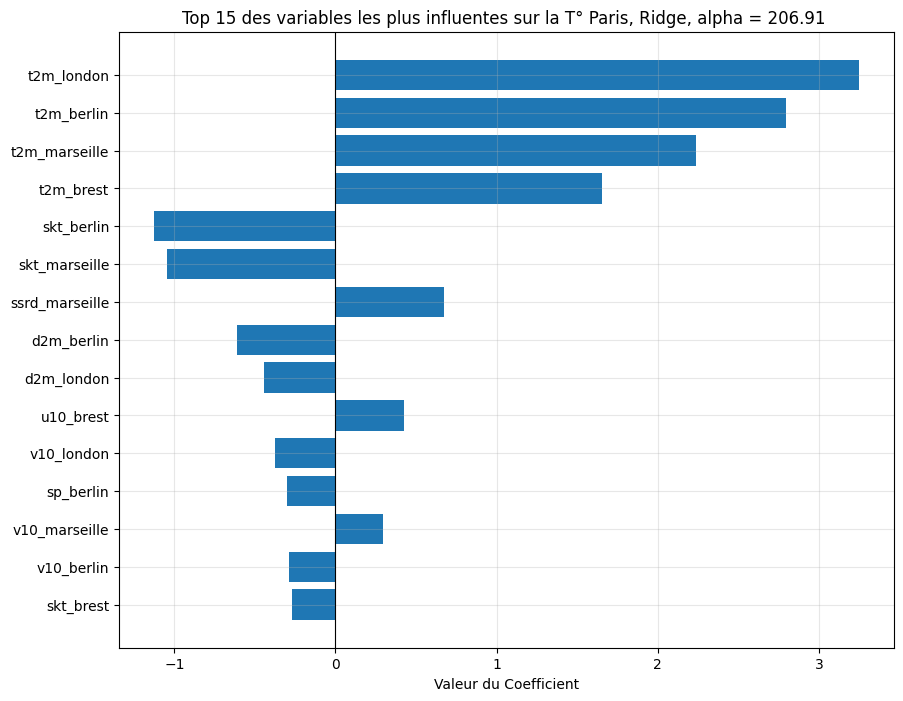

In [189]:
final_model = Ridge(alpha=complexity_best)
final_model.fit(X_cv_scaled, y_cv)

# Predictions
y_pred = final_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Résultats Finaux (Alpha = {complexity_best:.2f})")
print(f"RMSE sur le Test (2010+) : {rmse:.3f} °C")

# Coefficients
df_coef = pd.DataFrame({'Variable': feature_cols, 'Coeff': final_model.coef_})
# On les trie par importance
df_coef['Abs_Coeff'] = df_coef['Coeff'].abs()
# On prend les 15 variables les plus importantes
top_n = 15
df_plot = df_coef.sort_values(by='Abs_Coeff', ascending=True).tail(top_n)

plt.figure(figsize=(10, 8))
plt.barh(df_plot['Variable'], df_plot['Coeff'])
plt.xlabel("Valeur du Coefficient")
plt.title(f"Top {top_n} des variables les plus influentes sur la T° Paris, Ridge, alpha = {complexity_best:.2f} ")
plt.grid(True, alpha=0.3)
plt.axvline(0, color='black', linewidth=0.8)
plt.show()

On essaye de séparer en faisant un ridge pour chaque mois

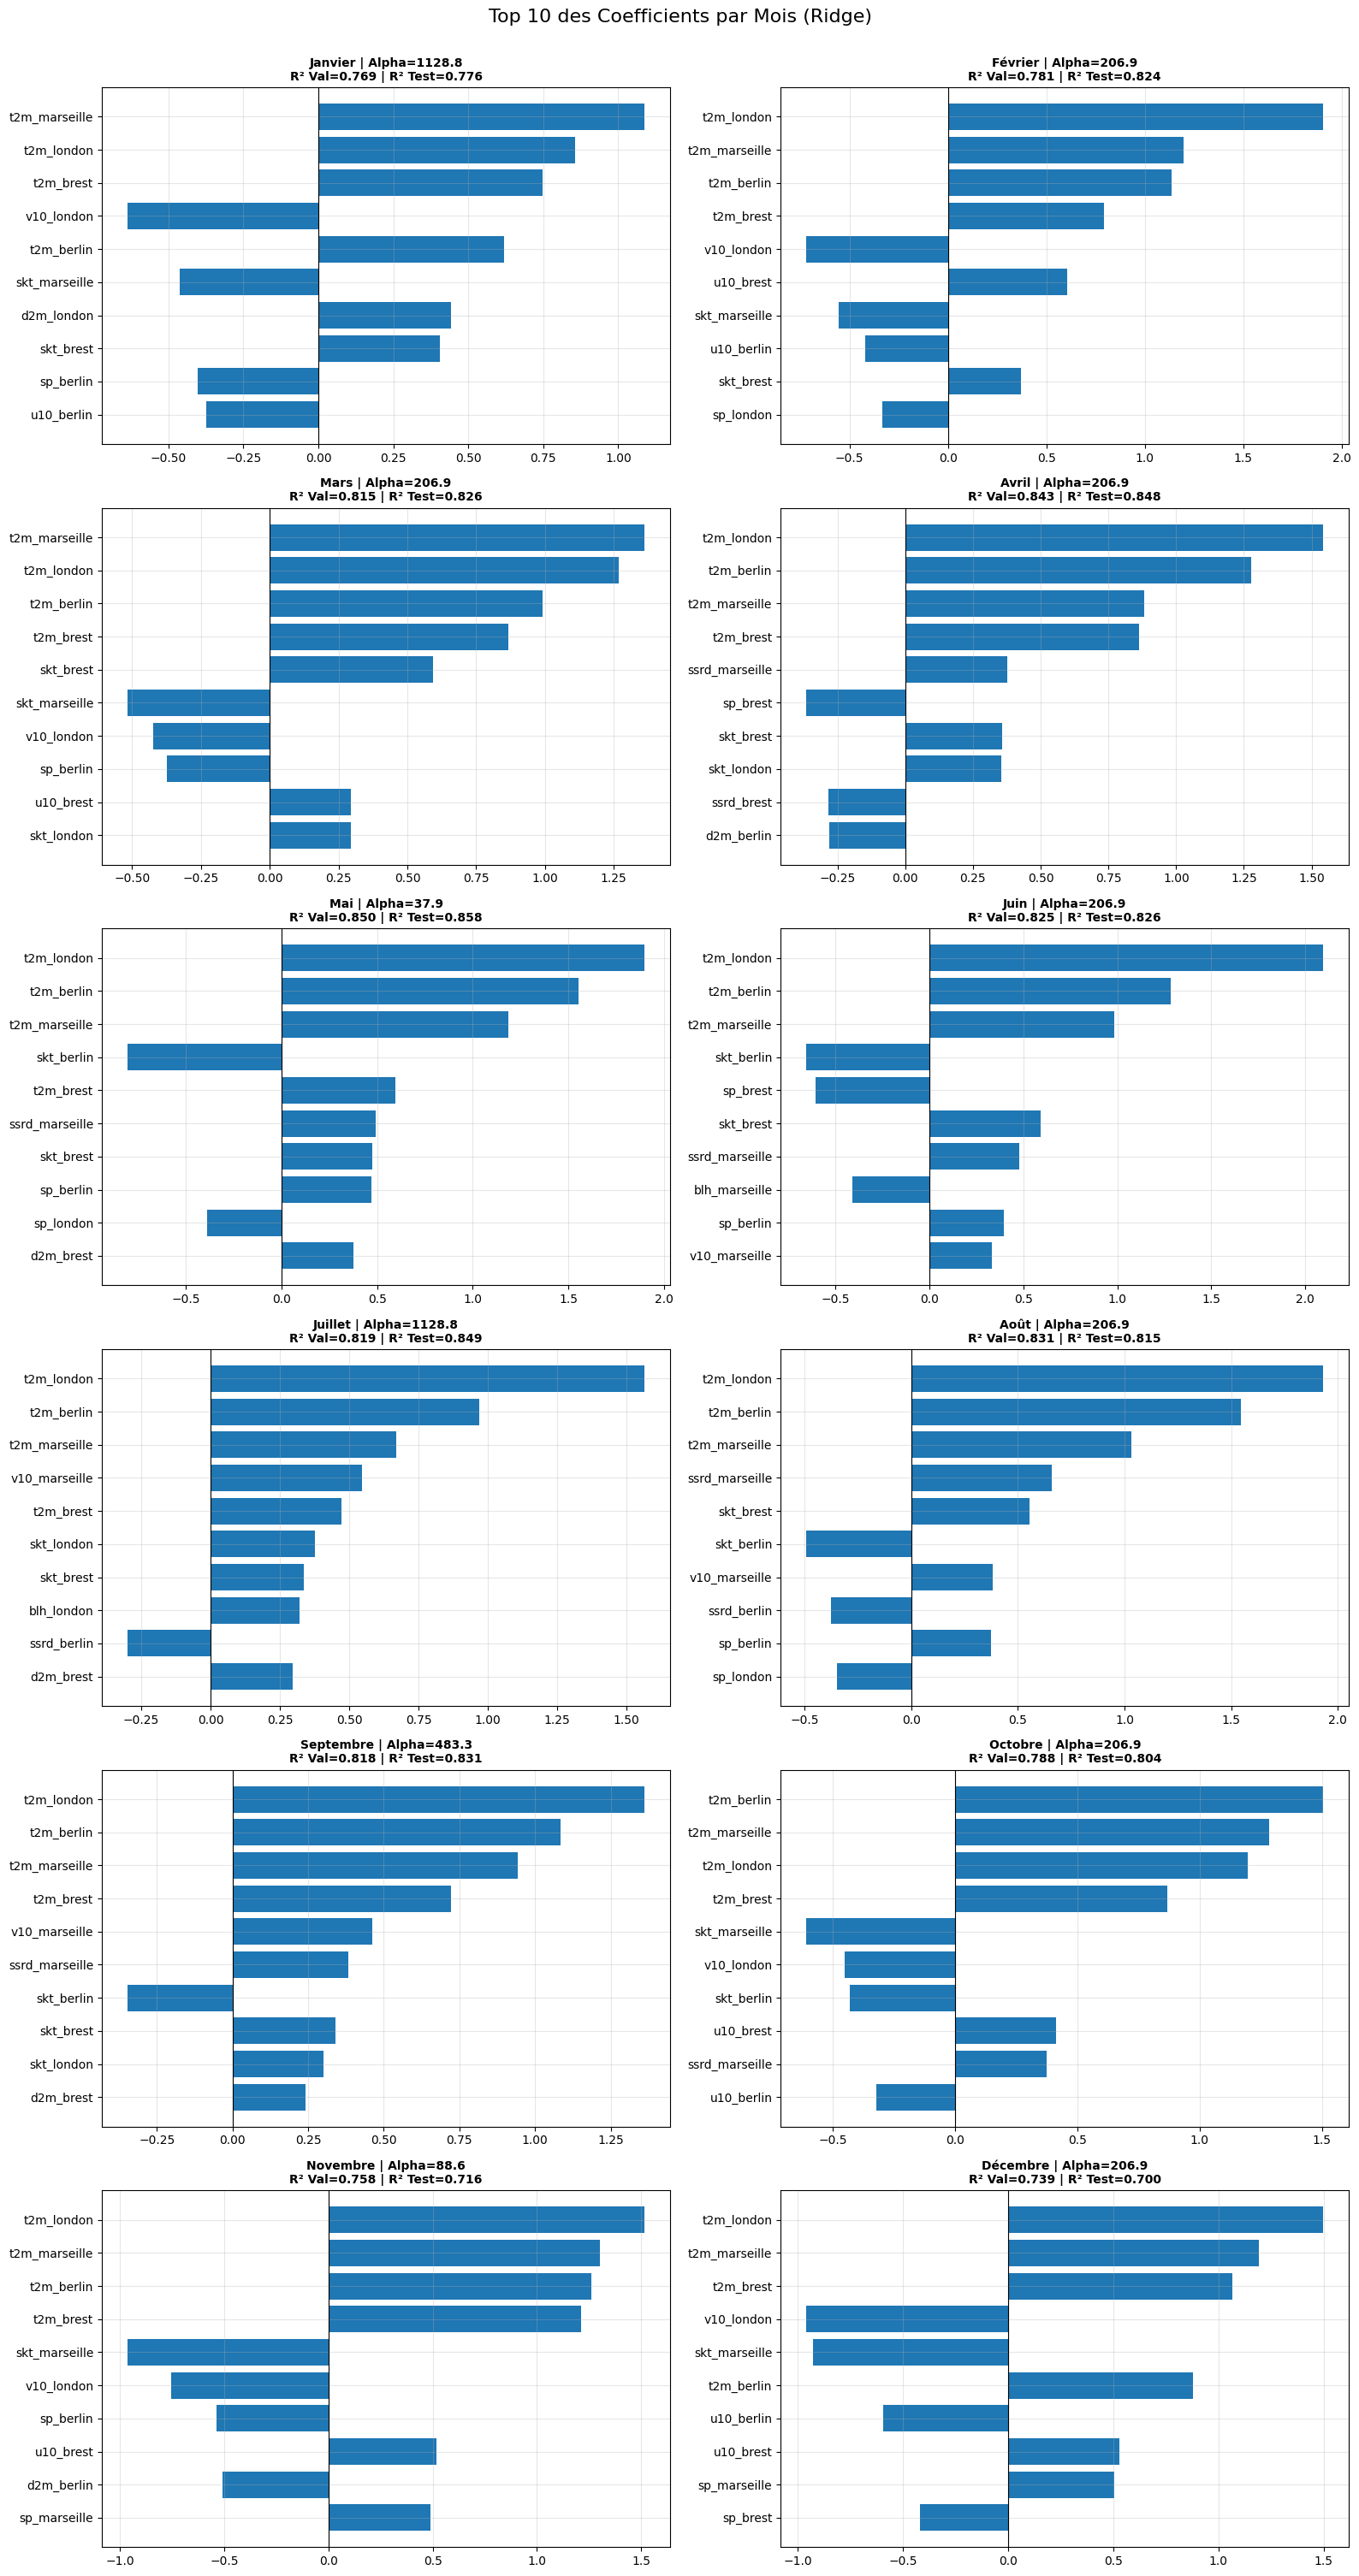

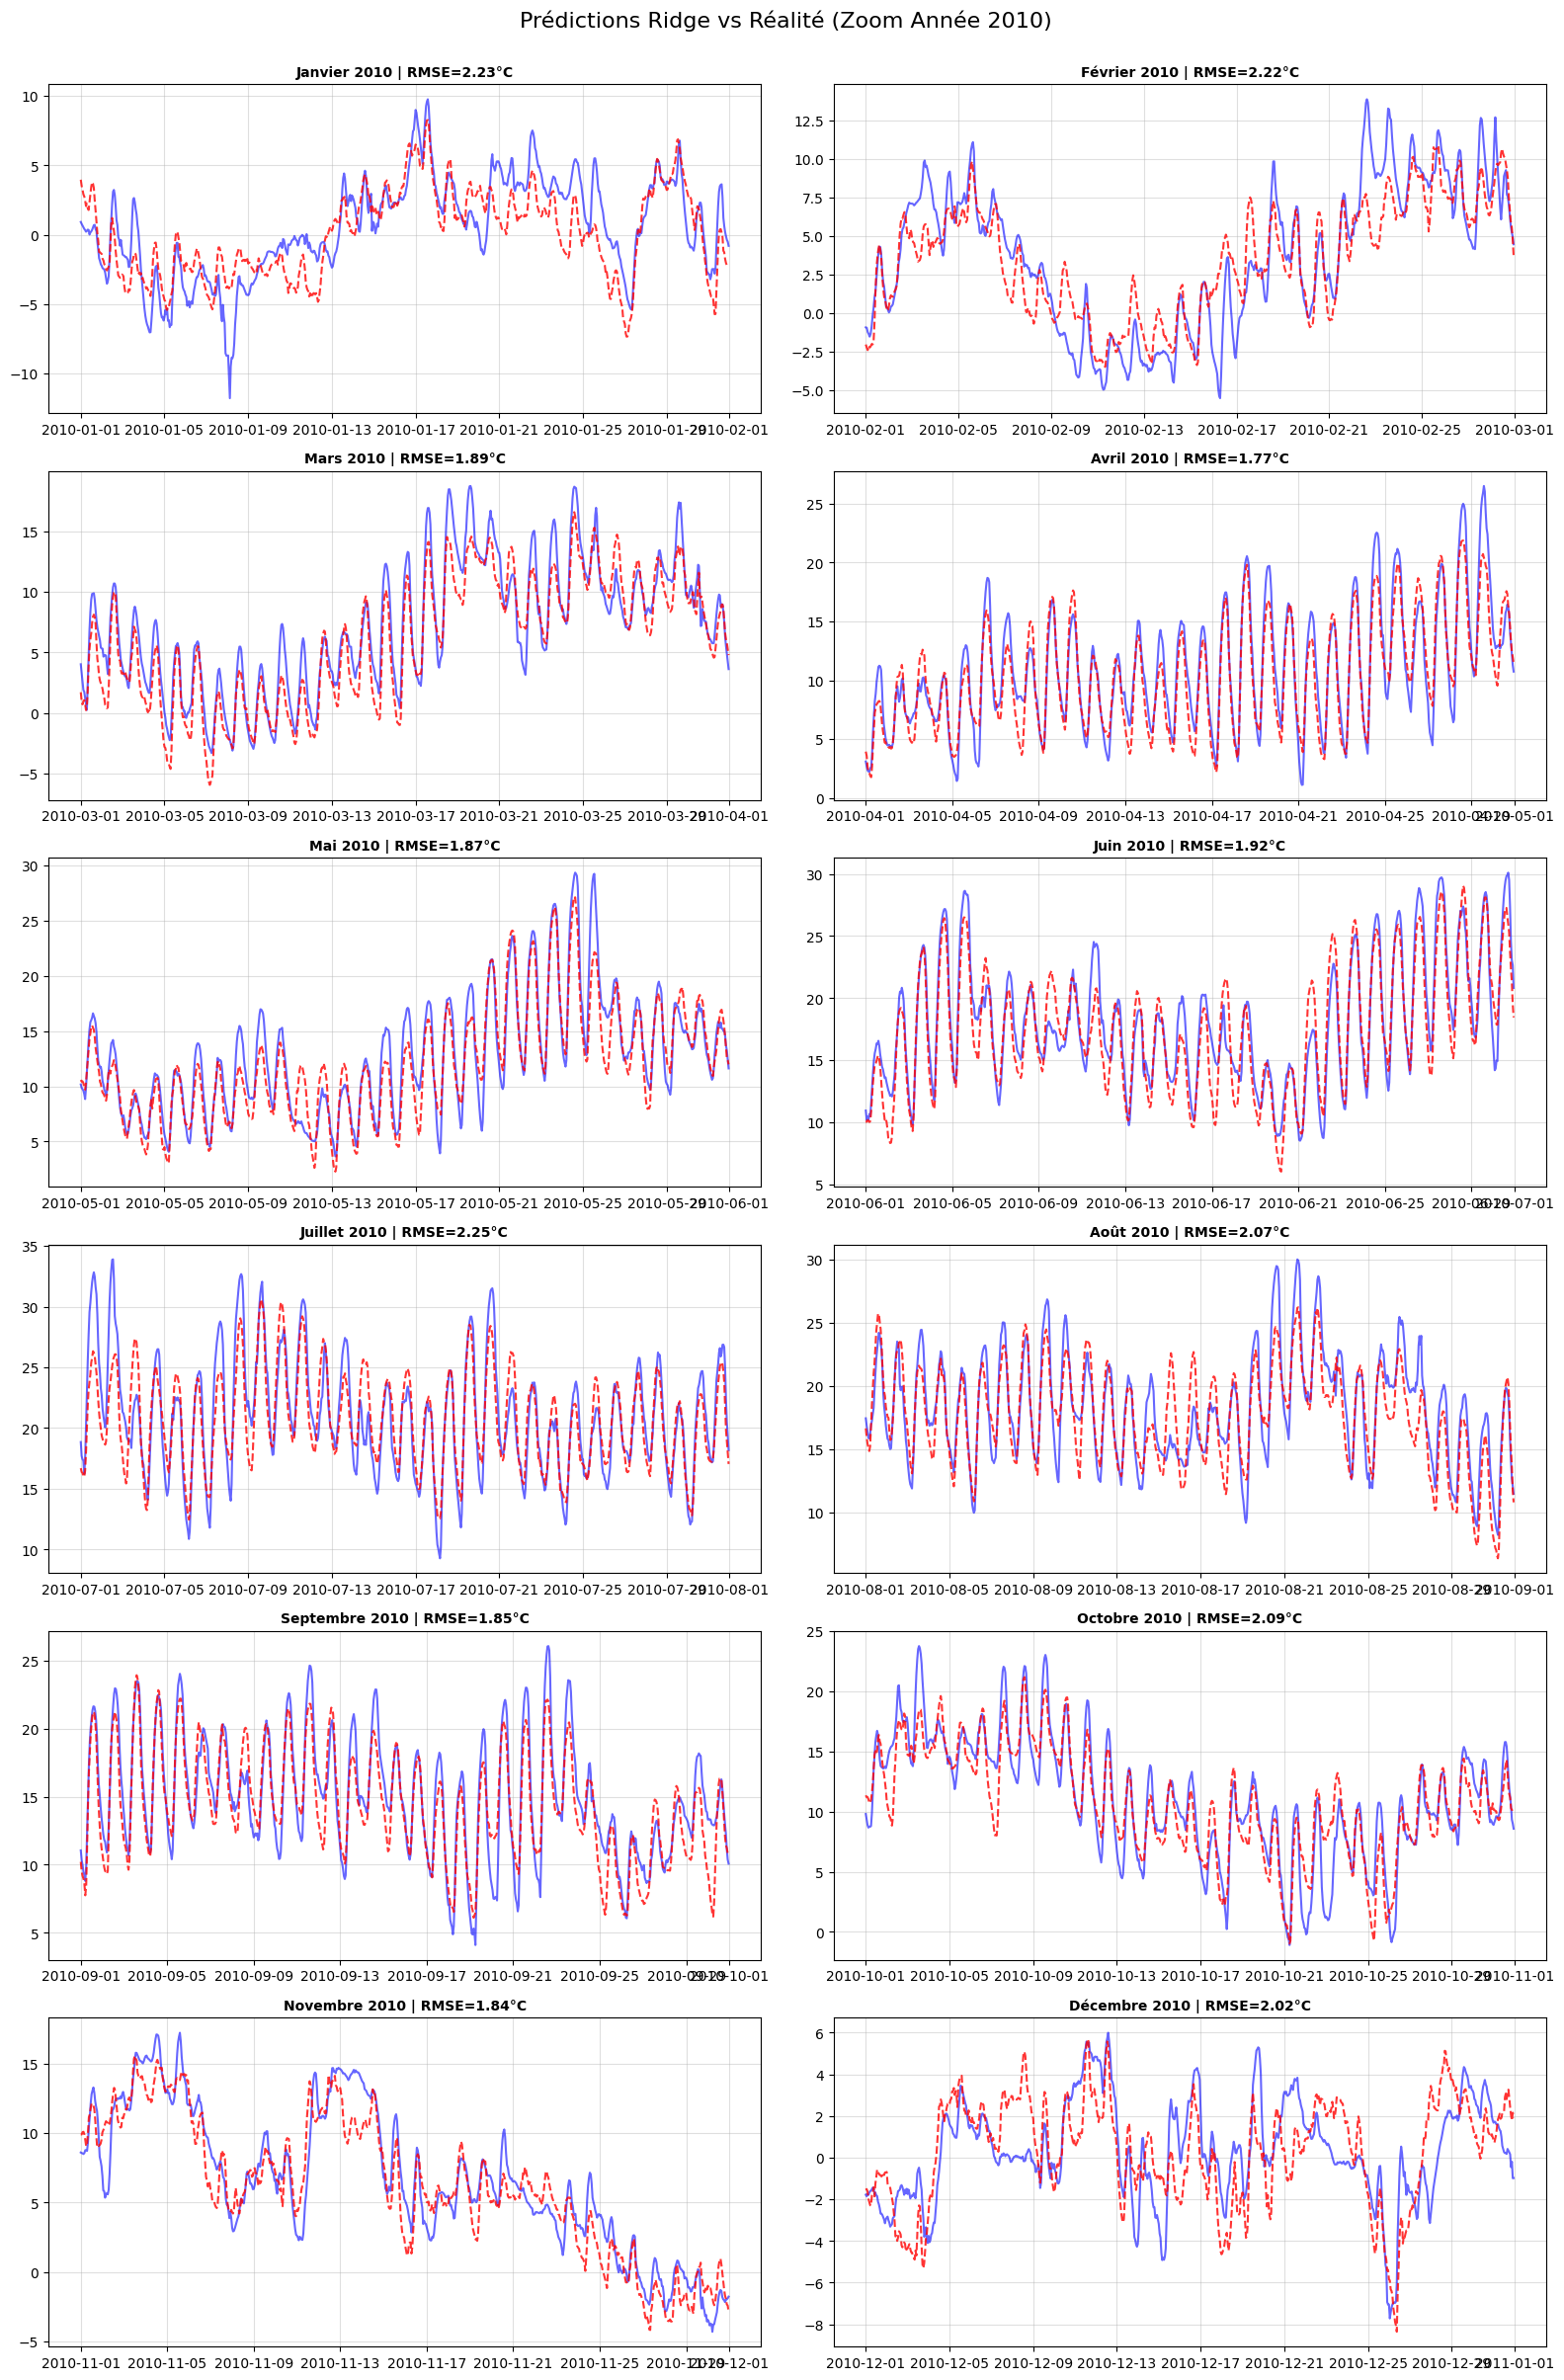

In [ ]:
target_col = "t2m_paris"
feature_cols = [c for c in df_all.columns if c != target_col and not c.endswith('paris')]
split_date = "2010-01-01"

complexity_rng= np.logspace(-1, 6, 20)

#Affichage pour la suite
mois_noms = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']


# Figure A : Coefficients 
fig_coef, ax_coef = plt.subplots(6, 2, figsize=(16, 30))
ax_coef = ax_coef.flatten()

# Figure B : Prédictions 2010 
fig_pred, ax_pred = plt.subplots(6, 2, figsize=(16, 24))
ax_pred = ax_pred.flatten()


# Boucle sur les mois
for month in range(1, 13):
    
    # On prépare les données du mois
    df_month = df_all[df_all.index.month == month]
    
    X = df_month[feature_cols]
    y = df_month[target_col]
    
    # Split
    X_cv = X.loc[X.index < split_date]
    y_cv = y.loc[y.index < split_date]
    X_test = X.loc[X.index >= split_date]
    y_test = y.loc[y.index >= split_date]
    
    # Scaling
    scaler = StandardScaler()
    X_cv_scaled = scaler.fit_transform(X_cv)
    X_test_scaled = scaler.transform(X_test)
    
    # Recherche meilleur alpha
    cv_split = TimeSeriesSplit(n_splits=3)
    r2_validation = []
    
    for alpha in complexity_rng:
        reg = Ridge(alpha=alpha)
        scores = cross_val_score(reg, X_cv_scaled, y_cv, cv=cv_split, scoring='r2')
        r2_validation.append(scores.mean())
        
    # Sélection du alpha
    best_idx = np.argmax(r2_validation)
    best_alpha = complexity_rng[best_idx]
    best_r2_val = r2_validation[best_idx]
    
    # Entrainement final avec le meilleur alpha
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(X_cv_scaled, y_cv)
    
    # Prédiction
    y_pred = final_model.predict(X_test_scaled)
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    
    real_r2_test = r2_score(y_test, y_pred)
    # Graphique des coefficients (top 10)
    df_c = pd.DataFrame({'Var': feature_cols, 'Coeff': final_model.coef_})
    df_c['Abs'] = df_c['Coeff'].abs()
    df_top = df_c.sort_values('Abs', ascending=True).tail(10)
    
    ax_c = ax_coef[month-1]
    ax_c.barh(df_top['Var'], df_top['Coeff'])
    ax_c.set_title(f"{mois_noms[month-1]} | Alpha={best_alpha:.1f}\nR² CV={best_r2_val:.3f} | R² Test 2010+={real_r2_test:.3f}", fontsize=10, fontweight='bold')
    ax_c.grid(True, alpha=0.3)
    ax_c.axvline(0, color='black', linewidth=0.8)
    
    # Graphique prédiction vs réel sur le mois de 2010
    y_real_2010 = y_test.loc['2010'] - 273.15 
    y_pred_2010 = y_pred_series.loc['2010'] - 273.15
    rmse_2010 = np.sqrt(mean_squared_error(y_real_2010, y_pred_2010))
    
    ax_p = ax_pred[month-1]
    ax_p.plot(y_real_2010.index, y_real_2010, label='Réel', color='blue', alpha=0.6)
    ax_p.plot(y_pred_2010.index, y_pred_2010, label='Prédit', color='red', linestyle='--', alpha=0.8)
    
    ax_p.set_title(f"{mois_noms[month-1]} 2010 | RMSE={rmse_2010:.2f}°C", fontsize=10, fontweight='bold')
    ax_p.grid(True, alpha=0.4)
    

fig_coef.suptitle("Top 10 des Coefficients par Mois (Ridge)", fontsize=16, y=1.002)
fig_coef.tight_layout()

fig_pred.suptitle("Prédictions Ridge vs Réalité (Zoom Année 2010)", fontsize=16, y=1.002)
fig_pred.tight_layout()

plt.show()

- On observe un plateau très stable pour les valeurs de alpha 